In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import os
from collections import Counter, defaultdict

In [62]:
df_trdc = pd.read_json('results_trdc.json')
df_trdc.head()

,file,directory,result
0,cond-args.bril,df,@main(cond: bool) {\n a: int = const 47;\n b...
1,cond.bril,df,@main {\n a: int = const 47;\n cond: bool = ...
2,fact.bril,df,@main {\n result: int = const 1;\n i: int = ...
3,loopcond.bril,dom,@main {\n.entry:\n x: int = const 0;\n i: in...
4,while.bril,dom,@main(a: int) {\n.while.cond:\n zero: int = c...


In [61]:
df_rdcl = pd.read_json('results_rdcl.json')
df_rdcl.head()

,file,directory,result
0,cond-args.bril,df,@main(cond: bool) {\n br cond .left .right;\n...
1,cond.bril,df,@main {\n cond: bool = const true;\n br cond...
2,fact.bril,df,@main {\n.header:\n zero: int = const 0;\n c...
3,loopcond.bril,dom,@main {\n.entry:\n one: int = const 1;\n.loop...
4,while.bril,dom,@main(a: int) {\n.while.cond:\n zero: int = c...


In [60]:
df_lvn = pd.read_json('results_lvn.json')
df_lvn.head()

,file,directory,result
0,cond-args.bril,df,@main(cond: bool) {\n br cond .left .right;\n...
1,cond.bril,df,@main {\n cond: bool = const true;\n br cond...
2,fact.bril,df,@main {\n result: int = const 1;\n i: int = ...
3,loopcond.bril,dom,@main {\n.entry:\n x: int = const 0;\n one: ...
4,while.bril,dom,@main(a: int) {\n.while.cond:\n zero: int = c...


In [117]:
BASE_DIR = "../../examples/test/"
ext = ".bril"
res = defaultdict(list)
avg = 0
assert len(df_trdc) == len(df_rdcl) == len(df_lvn)
dfs = ["trdc", "rdcl", "lvn"]
for i in range(len(df_trdc)):
    j = 0
    for data in [df_trdc.iloc[i], df_rdcl.iloc[i], df_lvn.iloc[i]]:
        k = data["file"].split(".")[0]
        d = data["directory"]
        filename = BASE_DIR + d + '/' + k + ext

        s = []
        with open(filename, 'r') as f:
            for line in f:
                s.append(line)
        num_lines_before = len(s)
        num_lines_after = data["result"].count('\n')
        diff = num_lines_before - num_lines_after
        # res[d+'+'+k] += [{dfs[j]: diff}]
        res[k] += [{dfs[j]: diff}]
        if j == 2:
            b = True
            num_lines_out = num_lines_before
            ext_out = ".out"
            pref = BASE_DIR + d + '/' + k
            filename = pref + ext_out
            s = []
            if not os.path.exists(filename):
                lst = glob.glob(pref + "*.out")
                if len(lst) == 0:
                    print("No out file found for", pref)
                    b = False
                else:
                    filename = lst[0]
                    b = True
            if b:
                with open(filename, 'r') as f:
                    for line in f:
                        s.append(line)
            num_lines_out = len(s)
            res[k].append({".out": num_lines_before - num_lines_out})
        avg += diff
        j += 1
avg /= len(df_trdc) * 3
res = dict(res)
len(res)

No out file found for ../../examples/test/dom/loopcond
No out file found for ../../examples/test/dom/while


38

In [118]:
res

{'cond-args': [{'trdc': 3}, {'rdcl': 5}, {'lvn': 5}, {'.out': 4}],
 'cond': [{'trdc': 3}, {'rdcl': 5}, {'lvn': 5}, {'.out': 5}],
 'fact': [{'trdc': 8}, {'rdcl': 10}, {'lvn': 10}, {'.out': 10}],
 'loopcond': [{'trdc': 7}, {'rdcl': 11}, {'lvn': 9}, {'.out': 30}],
 'while': [{'trdc': 1},
  {'rdcl': 1},
  {'lvn': 1},
  {'.out': 12},
  {'trdc': 2},
  {'rdcl': 2},
  {'lvn': 2},
  {'.out': 12},
  {'trdc': 1},
  {'rdcl': 1},
  {'lvn': 1},
  {'.out': -7}],
 'clobber-arg': [{'trdc': 1}, {'rdcl': 2}, {'lvn': 2}, {'.out': 0}],
 'clobber-fold': [{'trdc': 11}, {'rdcl': 13}, {'lvn': 15}, {'.out': 17}],
 'clobber': [{'trdc': 11}, {'rdcl': 13}, {'lvn': 15}, {'.out': 14}],
 'commute': [{'trdc': 3}, {'rdcl': 3}, {'lvn': 4}, {'.out': 2}],
 'divide-by-zero': [{'trdc': 1}, {'rdcl': 1}, {'lvn': 1}, {'.out': 0}],
 'fold-comparisons': [{'trdc': 19}, {'rdcl': 19}, {'lvn': 19}, {'.out': 5}],
 'idchain-nonlocal': [{'trdc': 2}, {'rdcl': 2}, {'lvn': 2}, {'.out': 1}],
 'idchain-prop': [{'trdc': 2}, {'rdcl': 2}, {'lv

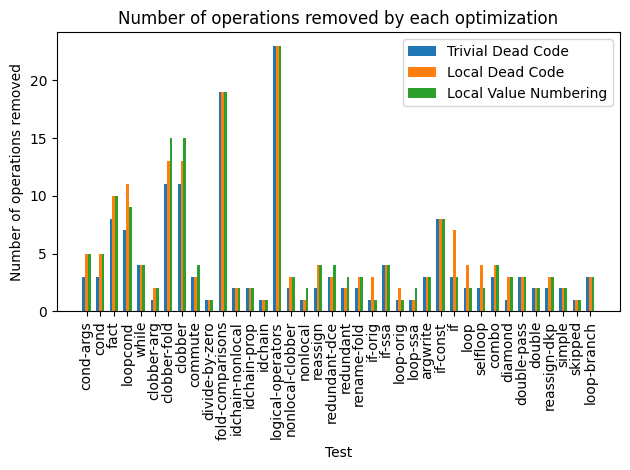

In [123]:
data = res

keys = list(data.keys())
categories = ['trdc', 'rdcl', 'lvn', '.out']
values = {category: [] for category in categories}

for key in keys:
    for category in categories:
        total = sum(d.get(category, 0) for d in data[key])
        values[category].append(total)

x = np.arange(len(keys))
width = 0.2

fig, ax = plt.subplots()
ax.bar(x - width, values['trdc'], width, label='Trivial Dead Code')
ax.bar(x, values['rdcl'], width, label='Local Dead Code')
ax.bar(x + width, values['lvn'], width, label='Local Value Numbering')
# ax.bar(x + 2 * width, values['.out'], width, label='BRIL Interpreter')

ax.set_xlabel('Test')
ax.set_ylabel('Number of operations removed')
ax.set_title('Number of operations removed by each optimization')
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()